In [12]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os, time
import re
from astropy.io import fits
from astropy.wcs import WCS
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from astroquery.astrometry_net import AstrometryNet
from astroquery.exceptions import TimeoutError
from a345_utilities import print_header    

ast = AstrometryNet()
ast.API_URL = 'http://nova.astro.gla.ac.uk/api' 
ast.api_key = 'XXXXXXXX'
ast.URL = 'http://nova.astro.gla.ac.uk'

cal_path = '/Volumes/external_2T/calibration/2023-10/neg10c/master/'
data_path = '/Volumes/external_2T/'
plate_path = data_path + 'platesolved_img2/'
stars = os.listdir(data_path)
exposure = '10s'      #Define the exposure of the images to calibrate
star_name = 'W UMa' 


In [13]:
cali_stars = np.loadtxt('calibration_stars.txt', delimiter = ',', skiprows=1)

id = cali_stars[:,0]
Ra = cali_stars[:,1]
De = cali_stars[:,2]
gmag = cali_stars[:,3]
g_err = cali_stars[:,4]
rmag = cali_stars[:,5]
r_err = cali_stars[:,6]
imag = cali_stars[:,7]
i_err = cali_stars[:,8]

Sending data to AstrometryNet server:
Solving.....................
 -> Success. Solving took 23.1s
Updated header, with WCS added:


Sending data to AstrometryNet server:
Solving....
 -> Success. Solving took 4.9s
Updated header, with WCS added:


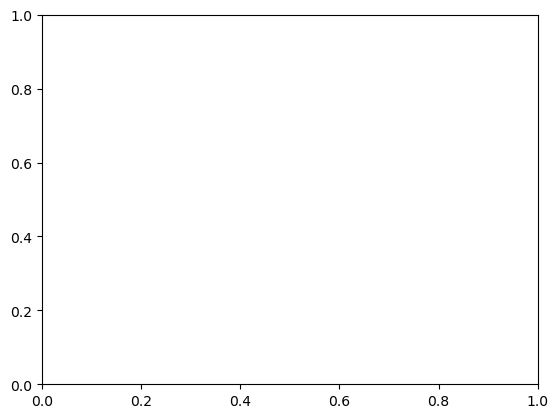

In [36]:
for star in stars:
    if re.search(star_name, star):
        col_band = os.listdir(data_path + star)
        
        col_band = col_band[1:]
        for band in col_band:
            files = os.listdir(data_path + star + '/' + band)
            for file in files:
                if file.endswith('.fits'):
                    with fits.open(data_path + star + '/' + band + '/' + file) as hdu:
                        data = hdu[0].data
                        header = hdu[0].header


                        # print_header(header)   

                        # fig1 = plt.figure(figsize=(16,16))
                        # # get some colour scaling for the image
                        # d_mean = np.mean(data);     # mean intensity
                        # d_std  = np.std(data);      # standard deviation of intensity
                        # vmin = d_mean - d_std/2     # brightness at colour scale minimum
                        # vmax = d_mean + d_std       # brightness at colour scale maximum

                        # # get it approximately the right way round
                        # data = np.rot90(data,1)


                        # im1 = plt.imshow(data, vmin = vmin, vmax=vmax, cmap='gray_r')
                        # plt.colorbar(im1, orientation='horizontal')

                        # plt.xlabel('x (pixels)')
                        # plt.ylabel('y (pixels)')
                        # plt.show()





                        bkg_sigma = mad_std(data)                                    # get a measure of the image noise level
                        daofind = DAOStarFinder(fwhm=6, threshold=20*bkg_sigma)     # set the detection threshold for a source based on the image noise
                        #             IRAFstarfinder()
                                                                                    # a lower theshold will give more sources, but will start picking up noise
                        sources = daofind(data)  
                        for col in sources.colnames:  
                            sources[col].info.format = '%.6g'  # for consistent table output 


                        sources.sort('flux') # sources are sorted by y position, more useful to sort them by flux
                        sources.reverse()  






                        # fig2 = plt.figure(figsize=(16,10))
                        # plt.imshow(data, vmin = vmin, vmax=vmax, cmap='gray_r')

                        # for each source plot a circular aperture, radius 8 pixels (these are normally used for photometry, but useful for plotting sources too)
                        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
                        apertures = CircularAperture(positions, r=30)  
                        p = apertures.plot(color='blue', lw=1.5, alpha=0.5)


                        image_width, image_height = data.shape
                        wcs_header = None             # this variable will hld the result from the solver when it has completed
                        t_start = time.time()
                        try:
                            print('Sending data to AstrometryNet server:')
                            wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                                                    image_width, image_height,
                                                                    solve_timeout=300)
                            if wcs_header:   # This will be true (ie not 'None') if the image solves sucessfully, and will contain a fits header with the solved image parameters (WCS)
                                print('\n -> Success. Solving took {:0.1f}s'.format(time.time()-t_start))
                                # print_header(wcs_header)         # the print_header function is in a345_utilities - see import statement at start. You can just use print(header), but it is a bit unwieldy

                                # update the existing header with the WCS data:
                                print('Updated header, with WCS added:')
                                header.update(wcs_header)   # add in the solved WCS info
                                # print_header(header)        # print the header with is added WCS data

                                # now save the calibrated file ready for analysis. This would normally be the end of a script like this:
                                # do any science analysis by loading the calibrated fits files from a different script
                                if re.search('_E_0',file):
    
                                    data = np.rot90(data)
                                    data = np.rot90(data)
                                # The easiest way to save the fils file is to create a new  fits abject, and add the data and calibrated header 
                                hdu = fits.PrimaryHDU()         # create a FITS HDU object
                                hdu.data = data
                                hdu.header = header
                                hdu.header.update(wcs_header)       # add in the header containg the wcs data


                                hdu.writeto(data_path + 'platesolved_img2/' + star + '/' + band + '/' + '_platesolved_' + file, overwrite = True)
                                wcs = WCS(header)


                            else:
                                print('\n -> Solving failed after {:0.1f}s'.format(time.time()-t_start))   



                        except TimeoutError:
                            #If you run out of time         
                            print('\n -> ##FAIL: Timeout while solving, try a longer timeout, optmise number of sources (200-800 seems about right)')
                        break

# for star in stars:
#     if re.search(star_name, star):
#         col_band = os.listdir(data_path + star)
        
#         col_band = col_band[1:]
#         for band in col_band:
#             files = os.listdir(data_path + star + '/' + band)
#             for file in files:
#                 if file.endswith('.fits'):

#                     with fits.open(plate_path + star + '/' + band + '/' + file) as hdu:
#                         reloaded_header = hdu[0].header
#                         reloaded_data   = hdu[0].data

#                     wcs = WCS(reloaded_header)
#                     wcs.printwcs()
#                     print(wcs.get_axis_types())

#                     fig = plt.figure(figsize=(10,18))
#                     ax = plt.subplot(projection=wcs)
#                     #get some colour limits
#                     mean_intensity = np.mean(data)
#                     r = 200
#                     plt.imshow(data,vmin=mean_intensity, vmax = mean_intensity+r, cmap='gray')    
#                     plt.grid(color='lightblue', ls='solid')    






#                     ax = plt.subplot(projection=wcs)
#                     plt.rcParams['figure.figsize'] = [25,25]
#                     ax = plt.gca()
#                     RA = ax.coords[0]
#                     DEC = ax.coords[1]

#                     RA.set_ticklabel(color='black', size=20)
#                     DEC.set_ticklabel(color='black', size=20)
#                     ax.set_xlabel('RA', fontsize=20)
#                     ax.set_ylabel('Dec', fontsize=20)
#                     ax.set_title('DAO starfinder sources (yellow), calibration stars (blue) and test target (red)',size=20)

#                     # plt.imshow(image_c, vmin=image_min,vmax=image_max,cmap='gray_r')
#                     plt.grid(color='white', ls='solid',linewidth=2)
#                     RA.set_ticks(number=10)
#                     DEC.set_ticks(number=10)

#                     # number of sources from DAO Starfinder to plot
#                     N_source=20
#                     # number of calibration stars to plot
#                     N_cal=2




#                     # plot yellow circles around the sources found by DAO starfinder
#                     positions_dao = np.transpose((sources['xcentroid'], sources['ycentroid']))  
#                     apertures_define = CircularAperture(positions_dao, r=25)
#                     apertures_dao=apertures_define[0:N_source+1]
#                     apertures_dao.plot(color='yellow', lw=1, alpha=1)

#                     # plot id labels on the figure which match thos eof DAO starfinder
#                     for j,p in enumerate(positions_dao[0:N_source+1]):
#                         plt.text(p[0]+10,p[1],sources['id'][j],fontsize=20,color='yellow')

#                     r1=12
#                     r2=r1+1
#                     r3=r2+4

#                     # plot blue circles around the calibration stars from VizieR
#                     source1_x, source1_y= wcs.wcs_world2pix(Ra,De,1)
#                     source1 = np.transpose((source1_x, source1_y))
#                     source1_aperture = CircularAperture(source1, r1)  
#                     source1_annulus = CircularAnnulus(source1, r2, r3)

#                     source1_phot = [source1_aperture, source1_annulus]
#                     source1_aperture.plot(color='blue', lw=2, alpha=1)
#                     source1_annulus.plot(color='deepskyblue', lw=2, alpha=1)

#                     for k in range(N_cal):
#                         plt.text(source1_x[k]-50,source1_y[k]-50,id_cal[k],fontsize=14,color='blue')





            
#                     # flip the y-axis to get dec increasing to the top
#                     plt.gca().invert_yaxis()
#                     plt.show()


                    


In [40]:
for star in stars:
    if re.search(star_name, star):
        col_band = os.listdir(data_path + star)
        
        col_band = col_band[1:]
        for band in col_band:
            files = os.listdir(data_path + star + '/' + band)
            for file in files:
                if file.endswith('.fits'):

                    with fits.open(plate_path + star + '/' + band + '/' + '_platesolved_' + file) as hdu:
                        reloaded_header = hdu[0].header
                        reloaded_data   = hdu[0].data

                    wcs = WCS(reloaded_header)
                    # wcs.printwcs()
                    # print(wcs.get_axis_types())

                    fig = plt.figure(figsize=(10,18))
                    ax = plt.subplot(projection=wcs)
                    #get some colour limits
                    mean_intensity = np.mean(data)
                    r = 200
                    plt.imshow(data,vmin=mean_intensity, vmax = mean_intensity+r, cmap='gray')    
                    plt.grid(color='lightblue', ls='solid')    






                    ax = plt.subplot(projection=wcs)
                    plt.rcParams['figure.figsize'] = [25,25]
                    ax = plt.gca()
                    RA = ax.coords[0]
                    DEC = ax.coords[1]

                    RA.set_ticklabel(color='black', size=20)
                    DEC.set_ticklabel(color='black', size=20)
                    ax.set_xlabel('RA', fontsize=20)
                    ax.set_ylabel('Dec', fontsize=20)
                    ax.set_title('DAO starfinder sources (yellow), calibration stars (blue) and test target (red)',size=20)

                    # plt.imshow(image_c, vmin=image_min,vmax=image_max,cmap='gray_r')
                    plt.grid(color='white', ls='solid',linewidth=2)
                    RA.set_ticks(number=10)
                    DEC.set_ticks(number=10)

                    # number of sources from DAO Starfinder to plot
                    N_source=20
                    # number of calibration stars to plot
                    N_cal=2




                    # plot yellow circles around the sources found by DAO starfinder
                    positions_dao = np.transpose((sources['xcentroid'], sources['ycentroid']))  
                    apertures_define = CircularAperture(positions_dao, r=25)
                    apertures_dao=apertures_define[0:N_source+1]
                    apertures_dao.plot(color='yellow', lw=1, alpha=1)

                    # plot id labels on the figure which match thos eof DAO starfinder
                    for j,p in enumerate(positions_dao[0:N_source+1]):
                        plt.text(p[0]+10,p[1],sources['id'][j],fontsize=20,color='yellow')

                    r1=12
                    r2=r1+1
                    r3=r2+4

                    # plot blue circles around the calibration stars from VizieR
                    source1_x, source1_y= wcs.wcs_world2pix(Ra,De,1)
                    source1 = np.transpose((source1_x, source1_y))
                    source1_aperture = CircularAperture(source1, r1)  
                    source1_annulus = CircularAnnulus(source1, r2, r3)

                    source1_phot = [source1_aperture, source1_annulus]
                    source1_aperture.plot(color='blue', lw=2, alpha=1)
                    source1_annulus.plot(color='deepskyblue', lw=2, alpha=1)

                    for k in range(N_cal):
                        plt.text(source1_x[k]-50,source1_y[k]-50,id_cal[k],fontsize=14,color='blue')





            
                    # flip the y-axis to get dec increasing to the top
                    plt.gca().invert_yaxis()
                    plt.show()


                    


TypeError: WCSAxes.__init__() got multiple values for argument 'wcs'

<Figure size 1000x1800 with 0 Axes>

NameError: name 'WCSAxes' is not defined